## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import tensorflow as tf
import data.data_selector as ds
import utils.plot_functions as pf
import utils.data_processing as dp
import matplotlib.pyplot as plt

In [3]:
def extract_overlapping_patches(images, out_shape, var_thresh, rand_state):
  """
  """
  num_patches, patch_size = out_shape
  patch_edge_size = np.int32(np.sqrt(patch_size))
  num_im, im_sizey, im_sizex = images.shape
  patches = np.zeros(out_shape, dtype=np.float32)
  i = 0
  while i < num_patches:
    row = rand_state.randint(im_sizey - patch_edge_size)
    col = rand_state.randint(im_sizex - patch_edge_size)
    patch = images[rand_state.randint(num_im),
      row:row+patch_edge_size, col:col+patch_edge_size]
    if np.var(patch) > var_thresh:
      patches[i, :] = np.reshape(patch, patch_size)
      i = i+1
  return patches

In [4]:
def extract_random_tiled_patches(images, out_shape, var_thresh, rand_state):
  """
  """
  num_patches, patch_size = out_shape
  patch_edge_size = np.int32(np.sqrt(patch_size))
  num_im, im_sizey, im_sizex = images.shape
  num_available_patches = num_im * np.floor(im_sizex/patch_edge_size)**2
  assert num_patches <= num_available_patches, (
    "The number of requested patches (%g) must be less than or equal to %g"%(
      num_patches, num_available_patches))
  if im_sizex % patch_edge_size != 0: # crop columns
    crop_x = im_sizex % patch_edge_size
    crop_edge = np.int32(np.floor(crop_x/2.0))
    images = images[:, crop_edge:im_sizex-crop_edge, :]
    im_sizex = images.shape[1]
  if im_sizey % patch_edge_size != 0: # crop rows
    crop_y = im_sizey % patch_edge_size
    crop_edge = np.int32(np.floor(crop_y/2.0))
    images = images[:, :, crop_edge:im_sizey-crop_edge]
    im_sizey = images.shape[2]
  # Tile column-wise, then row-wise
  patches = np.asarray(np.split(images, im_sizex/patch_edge_size, 2))
  patches = np.asarray(np.split(patches, im_sizey/patch_edge_size, 2))
  patches = np.transpose(np.reshape(np.transpose(patches, axes=(3,4,0,1,2)),
    (patch_edge_size, patch_edge_size, -1)), axes=(2,0,1))
  patches = patches[(np.var(patches, axis=(1,2)) > var_thresh)]
  if patches.shape[0] < num_patches:
    assert False, (
      "out_shape requres too many patches (%g); maximum available is %g."%(
      num_patches, patches.shape[0]))
  else:
    patch_keep_idx = rand_state.choice(patches.shape[0], num_patches,
      replace=False)
    patch_keep_idx = np.arange(num_patches)
    patches = patches[patch_keep_idx, ...]
  return patches

In [5]:
def extract_tiled_patches(images, out_shape):
  """
  """
  num_patches, patch_size = out_shape
  patch_edge_size = np.int32(np.sqrt(patch_size))
  num_im, im_sizey, im_sizex = images.shape
  assert im_sizey == im_sizex, ("Input images must be square.")
  img_edge_size = im_sizex
  assert im_sizex % patch_edge_size == 0, (
    "Requested patch_edge_size, %g does not divide into image edge size, %g"%(
    patch_edge_size, img_edge_size))
  num_patches_per_side = img_edge_size/patch_edge_size
  num_patches_per_img = num_patches_per_side**2
  tot_num_patches =  num_patches_per_img * num_im
  assert num_patches <= tot_num_patches, (
    "The requested number of patches, %g, is less than the number of available patches, %g"%(
    num_patches, tot_num_patches))
  patches = np.zeros((num_patches, patch_edge_size, patch_edge_size))
  img_pos = 0
  x_pos = 0
  y_pos = 0
  for patch_idx in range(num_patches):
    patches[patch_idx, ...] = images[img_pos, x_pos:x_pos+patch_edge_size, y_pos:y_pos+patch_edge_size]
    y_pos += patch_edge_size
    if y_pos >= img_edge_size:
      y_pos = 0
      x_pos += patch_edge_size
    if x_pos >= img_edge_size:
      x_pos = 0
    if patch_idx >= (img_pos+1)*num_patches_per_img:
      img_pos += 1
      x_pos = 0
      y_pos = 0
  return patches

In [6]:
def extract_patches(images, out_shape, overlapping=False, randomize=False, var_thresh=0,
  rand_state=np.random.RandomState()):
  """
  Extract patches from image dataset.
  Inputs:
    images [np.ndarray] of shape [num_images, img_height, img_width]
    out_shape [tuple or list] containing the 2-d output shape
      [num_patches, patch_size] where patch_size has an even sqrt
    overlapping [bool] specify if the patches are evenly tiled or randomly drawn
    randomize [bool] specify if the patches are drawn randomly (must be True for overlapping)
    var_thresh [float] acceptance threshold for patch pixel variance. If it is
      below threshold then reject the patch.
  Outputs:
    patches [np.ndarray] of patches
  """
  images = dp.reshape_data(images, flatten=False)[0]
  num_im, im_sizey, im_sizex = images.shape
  (num_patches, patch_size) = out_shape
  assert np.floor(np.sqrt(patch_size)) == np.ceil(np.sqrt(patch_size)), (
    "Patch size must have an even square root.")
  patch_edge_size = np.int32(np.sqrt(patch_size))
  if (patch_edge_size <= 0 or patch_edge_size == im_sizey):
    if num_patches < num_im:
      im_keep_idx = rand_state.choice(images.shape[0], num_patches, replace=False)
      return images[im_keep_idx, ...]
    elif num_patches == num_im:
      return images
    else:
      assert False, (
        "The number of requested %g pixel patches must be less than or equal to %g"%(
        patch_size, num_im)) #TODO: Test this error msg
  if overlapping:
    patches = extract_overlapping_patches(images, out_shape, var_thresh, rand_state)
  else:
    if randomize:
      patches = extract_random_tiled_patches(images, out_shape, var_thresh, rand_state)
    else:
      patches = extract_tiled_patches(images, out_shape)
  return patches

In [7]:
def patches_to_image(data, num_imgs, patch_edge_size, img_edge_size):
  assert img_edge_size%patch_edge_size == 0, ("Patches must divide evenly into the image.")
  (data, orig_shape, num_examples, num_rows, num_cols) = dp.reshape_data(data, flatten=False)
  num_patches_per_side = img_edge_size/patch_edge_size
  num_patches_per_img = num_patches_per_side**2
  img = np.zeros((num_imgs, img_edge_size, img_edge_size))
  img_pos = 0
  x_pos = 0
  y_pos = 0
  for patch_idx in range(data.shape[0]):
    img[img_pos, x_pos:x_pos+patch_edge_size, y_pos:y_pos+patch_edge_size] = data[patch_idx, ...]
    y_pos += patch_edge_size
    if y_pos >= img_edge_size:
      y_pos = 0
      x_pos += patch_edge_size
    if x_pos >= img_edge_size:
      x_pos = 0
    if patch_idx >= (img_pos+1)*num_patches_per_img:
      img_pos += 1
      x_pos = 0
      y_pos = 0
  return img

In [8]:
def plot_data_tiled(data, normalize=False, title="", vmin=None, vmax=None,
  save_filename=None):
  """
  Save figure for input data as a tiled image
  Inpus:
    data: [np.ndarray] of shape:
      (height, width) - single image
      (n, height, width) - n images tiled with dim (height, width)
      (n, height, width, features) - n images tiled with dim
        (height, width, features); features could be color
    normalize: [bool] indicating whether the data should be streched (normalized)
      This is recommended for dictionary plotting.
    title: [str] for title of figure
    vmin, vmax: [int] the min and max of the color range
    save_filename: [str] holding output directory for writing,
      figures will not display with GUI if set
  """
  if normalize:
    data = dp.normalize_data_with_max(data)
    vmin = -1.0
    vmax = 1.0
  if vmin is None:
    vmin = np.min(data)
  if vmax is None:
    vmax = np.max(data)
  if len(data.shape) >= 3:
    data = pf.pad_data(data)
  fig, sub_axis = plt.subplots(1, figsize=(24, 24))
  axis_image = sub_axis.imshow(data, cmap="Greys_r", interpolation="nearest")
  axis_image.set_clim(vmin=vmin, vmax=vmax)
  cbar = pf.add_colorbar_to_im(axis_image)
  #cbar = fig.colorbar(axis_image)
  sub_axis.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  sub_axis.get_xaxis().set_visible(False)
  sub_axis.get_yaxis().set_visible(False)
  sub_axis.set_title(title, fontsize=24)
  if save_filename is not None:
    if save_filename == "":
      save_filename = "./output.png"
    fig.savefig(save_filename, transparent=True, bbox_inches="tight", pad_inches=0.01)
    plt.close(fig)
    return None
  plt.show()
  return fig

In [9]:
def plot_weights(weights):
  num_plots = weights.shape[0]
  num_plots_y = int(np.ceil(np.sqrt(num_plots))+1)
  num_plots_x = int(np.floor(np.sqrt(num_plots)))
  fig, sub_ax = plt.subplots(num_plots_y, num_plots_x, figsize=(18,18))
  filter_total = 0
  for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
    if filter_total < num_plots:
      sub_ax[plot_id].imshow(weights[filter_total, ...], cmap="Greys_r")
      filter_total += 1
    pf.clear_axis(sub_ax[plot_id])
    sub_ax[plot_id].set_aspect("equal")
  plt.show()
  return fig

In [10]:
def plot_phase_avg_power_spec(data, title="", save_filename=None):
  """
  Plot phase averaged power spectrum for a set of images
  Inputs:
    data: [np.ndarray] of shape:
      (n, i, j) - n data points, each of shape (i,j)
      (n, k) - n data points, each of length k
      (k) - single data point of length k (k must have even sqrt)
    title: [str] for title of figure
    save_filename: [str] holding output directory for writing,
      figures will not display with GUI if set
  """
  pspec = dp.phase_avg_pow_spec(data)
  (fig, ax) = plt.subplots(len(pspec), sharex=True, figsize=(20,20))
  for i in range(len(pspec)):
    ax[i].loglog(range(pspec[i][pspec[i]>1].shape[0]), pspec[i][pspec[i]>1])
    ax[i].set_aspect("equal")
    #ax[i].loglog(range(pspec[i].shape[0]), pspec[i])
  #(fig, ax) = plt.subplots()
  #ax.loglog(range(pspec[pspec>1].shape[0]), pspec[pspec>1])
  #ax.loglog(range(pspec.shape[0]), pspec)
  #fig.suptitle(title, y=1.0, x=0.5)
  plt.tight_layout()
  if save_filename is not None:
      fig.savefig(save_filename)
      plt.close(fig)
      return None
  plt.show()
  return fig

In [10]:
def whiten_data(data, method="FT", num_dim=-1):
  """
  Whiten data
  Inputs:
    data: [np.ndarray] of shape:
      (n, i, j) - n data points, each of shape (i,j)
      (n, k) - n data points, each of length k
      (k) - single data point of length k
    method: [str] method to use, can be {FT, PCA, ZCA}
    num_dim: [int] specifies the number of PCs to use for PCA method
  Outputs:
    whitened_data, filter used for whitening
  """
  if method == "FT":
    (data, orig_shape, num_examples, num_rows, num_cols) = dp.reshape_data(data,
      flatten=False) # Need spatial dim for 2d-Fourier transform
    data -= data.mean(axis=(1,2))[:,None,None]
    dataFT = np.fft.fftshift(np.fft.fft2(data, axes=(1, 2)), axes=(1, 2))
    nyq = np.int32(np.floor(num_rows/2))
    freqs = np.linspace(-nyq, nyq-1, num=num_rows)
    fspace = np.meshgrid(freqs, freqs)
    rho = np.sqrt(np.square(fspace[0]) + np.square(fspace[1]))
    lpf = np.exp(-0.5 * np.square(rho / (0.7 * nyq)))
    w_filter = np.multiply(rho, lpf) # filter is in the frequency domain
    dataFT_wht = np.multiply(dataFT, w_filter[None, :])
    data_wht = np.real(np.fft.ifft2(np.fft.ifftshift(dataFT_wht, axes=(1, 2)), axes=(1, 2)))
    if data_wht.shape != orig_shape:
      data_wht = dp.reshape_data(data_wht, flatten=True)[0]
  elif method == "PCA":
    (data, orig_shape, num_examples, num_rows, num_cols) = dp.reshape_data(data, flatten=True)
    data -= data.mean(axis=(1))[:, None]
    cov = np.divide(np.dot(data.T, data), num_examples)
    evals, evecs = np.linalg.eig(cov)
    isqrtEval = np.diag(1 / np.sqrt(evals+1e-6)) # TODO: Should maybe threshold instead of adding eps?
    w_filter = np.dot(np.dot(evecs, isqrtEval), evecs.T) # filter is in the spatial domain
    data_wht = np.dot(data, w_filter)
  elif method == "ZCA":
    (data, orig_shape, num_examples, num_rows, num_cols) = dp.reshape_data(data, flatten=True)
    data -= data.mean(axis=(1))[:, None]
    cov = np.divide(np.dot(data.T, data), num_examples)
    u, s, v = np.linalg.svd(cov)
    isqrtS = np.diag(1 / np.sqrt(s+1e-6)) # TODO: Should maybe threshold instead of adding eps?
    w_filter = np.dot(u, np.dot(isqrtS, u.T))
    data_wht = np.dot(data, w_filter.T)
  else:
    assert False, ("whitening method must be 'FT', 'SVD', or 'PCA'")
  return data_wht, w_filter

In [16]:
params = {
  "data_type": "vanHateren",
  "whiten_images": False,
  "contrast_normalize": False,
  "epoch_size": 50, #1024
  "patch_edge_size": 512, #16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 0,
  "conv": False,
  "batch_size": 100,
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/"}

In [12]:
data = ds.get_data(params)

In [21]:
print(data["train"].images.shape)

(50, 262144)


In [17]:
full_img = dp.reshape_data(data["train"].images, flatten=False)[0]
patch_shape = (int(params["epoch_size"]*(params["patch_edge_size"]/16)**2), 256)
img_patches = extract_patches(full_img, patch_shape, overlapping=params["overlapping_patches"], 
  randomize=params["randomize_patches"], var_thresh=params["patch_variance_threshold"])
recon_full_img = patches_to_image(img_patches, params["epoch_size"], patch_edge_size=16, img_edge_size=512)

In [18]:
ft_wht_data = whiten_data(full_img, method="FT")[0]
pca_wht_patches = whiten_data(img_patches, method="PCA")[0]
pca_wht_data = patches_to_image(pca_wht_patches, params["epoch_size"], patch_edge_size=16, img_edge_size=512)
zca_wht_patches = whiten_data(img_patches, method="ZCA")[0]
zca_wht_data = patches_to_image(zca_wht_patches, params["epoch_size"], patch_edge_size=16, img_edge_size=512)

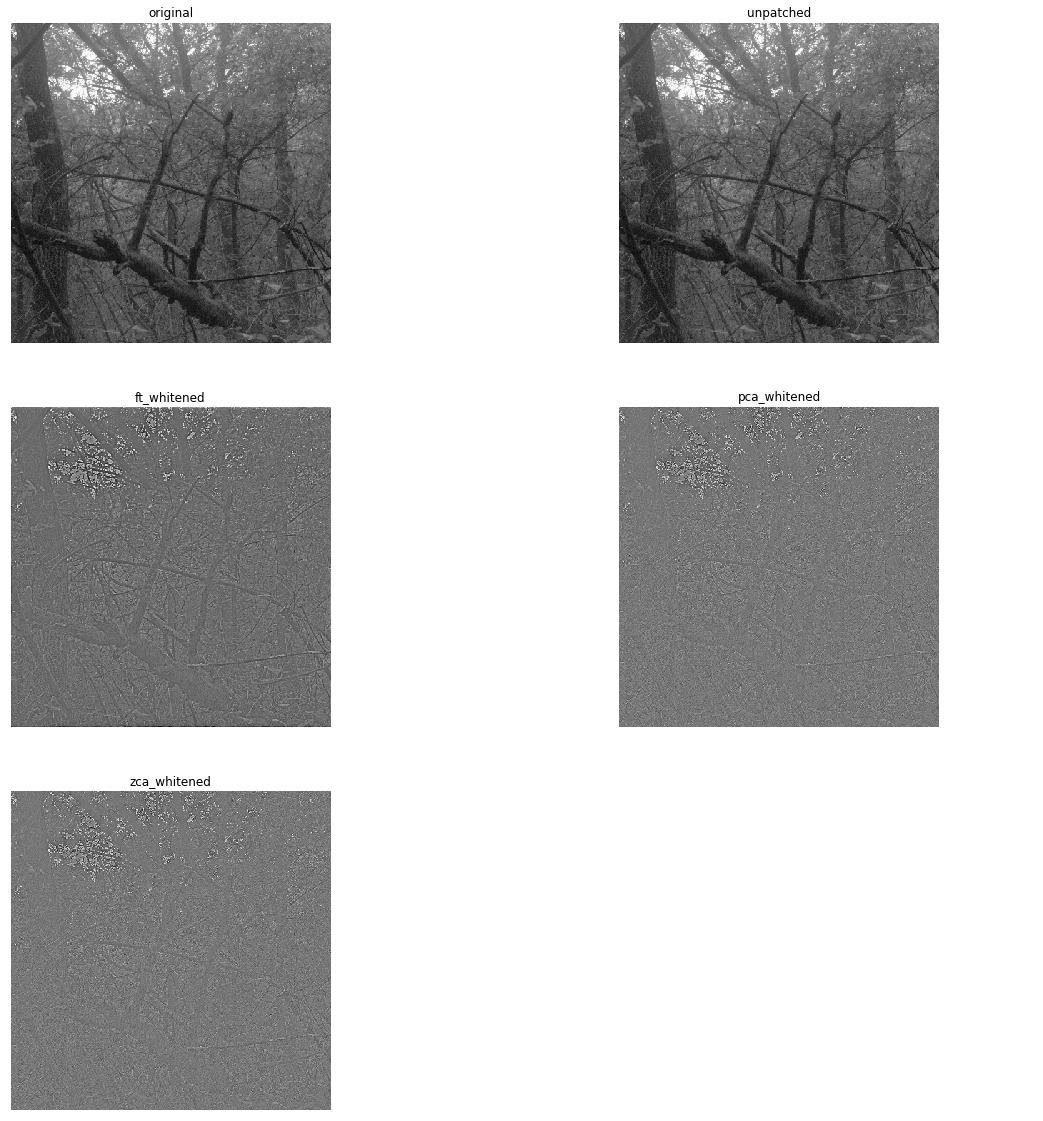

In [19]:
data_set = [full_img, recon_full_img, ft_wht_data, pca_wht_data, zca_wht_data]
data_keys = ["original", "unpatched", "ft_whitened", "pca_whitened", "zca_whitened"]
img_idx = np.random.choice(params["epoch_size"], 1)[0]
num_plots_y = int(np.ceil(np.sqrt(len(data_set))))
num_plots_x = int(np.floor(np.sqrt(len(data_set))))
fig, ax = plt.subplots(num_plots_y, num_plots_x, figsize=(20, 20))
img_count = 0
for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
  ax[plot_id] = pf.clear_axis(ax[plot_id])
  if img_count < len(data_set):
    ax[plot_id].imshow(data_set[img_count][img_idx,...], cmap="Greys_r")
    ax[plot_id].set_title(data_keys[img_count])
    img_count += 1
plt.show()

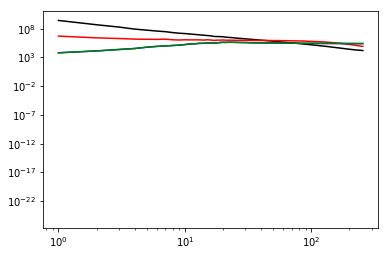

In [20]:
pspec = dp.phase_avg_pow_spec(full_img)
avg_pspec = np.mean(pspec, axis=0)

ft_pspec = dp.phase_avg_pow_spec(ft_wht_data)
avg_ft_pspec = np.mean(ft_pspec, axis=0)

pca_pspec = dp.phase_avg_pow_spec(pca_wht_data)
avg_pca_pspec = np.mean(pca_pspec, axis=0)

zca_pspec = dp.phase_avg_pow_spec(zca_wht_data)
avg_zca_pspec = np.mean(zca_pspec, axis=0)

(fig, ax) = plt.subplots(1)
ax.loglog(range(avg_pspec.shape[0]), avg_pspec, 'k')
ax.loglog(range(avg_ft_pspec.shape[0]), avg_ft_pspec, 'r')
ax.loglog(range(avg_pca_pspec.shape[0]), avg_pca_pspec, 'b')
ax.loglog(range(avg_zca_pspec.shape[0]), avg_zca_pspec, 'g')
plt.show()